# look into:
 - look into tdnn
 - convs for discrim
 - lstms for discrim
 - convs for gen
 - lstms for gen

In [899]:
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [900]:
in_shape = 200

In [901]:
class sinDataLoader(Dataset):
    def __init__(self,start,end,offset = np.pi*2):
        self.start = start
        self.end = end
        self.pspace = np.arange(start,end+1)
        self.offset = offset
    def return_sin_wave(self, sinmod=1,step = 1/in_shape):
        x = np.linspace(0,int(self.offset),int(1/step))
        y = np.sin(x*(sinmod*step))
        return y
    def __len__(self):
        return len(self.pspace)
    def __getitem__(self,index):
        return self.return_sin_wave(sinmod = self.pspace[index])

In [902]:
fmin = 100 + 1000
fmax = 1000 + 1000
dl = DataLoader(sinDataLoader(fmin,fmax,offset = 1),batch_size = 16,shuffle = True)

In [903]:
# plt.plot(next(iter(dl))[8])
# next(iter(dl))[0].shape

In [904]:
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torch


In [905]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(in_shape, 512*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512*4, 512*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512*2, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, inp):
        validity = self.model(inp)
        return validity


In [927]:
activation_func = nn.GELU()
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat,eps = 0.00001, momentum=.8))
            layers.append(activation_func)
            layers.append(nn.Tanh())
            return layers

        self.modelL = nn.Sequential(
            *block(1, 128, normalize=False),
            *block(128,128*4),
            *block(128*4, 256*4),
            *block(256*4, 512*4),
            *block(512*4, 1024*4),
            *block(1024*4,1024*8),
            nn.Linear(1024*8,1024*16),
            nn.Linear(1024*16, in_shape),
            nn.Tanh()
        )
        self.modelS = nn.Sequential(
            *block(1, 64, normalize=False),
            *block(64,128),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, in_shape),
            nn.Tanh()
        )
    def forward(self,inp):
            return self.modelS(inp)


In [928]:
lambda_gp = 10
cuda = torch.cuda.is_available()

In [929]:
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()


In [930]:

optimizer_G = torch.optim.Adam(
    generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [931]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
import sys

In [932]:
def innoise(shape):
    return Variable(torch.abs(Tensor(np.random.normal(
            1.1, .1, (shape[0], 1)))))

In [933]:
from icecream import ic

In [934]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1,real_samples.shape[0],1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. 
    # ic(d_interpolates.shape,interpolates.shape,fake.shape)
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty



In [935]:
tracked_d_loss = np.array([])
tracked_g_loss = np.array([])


In [936]:
batches_done = 0
n_epochs = 40

In [937]:
lenEpochs = len(str(n_epochs))
lenDl = len(str(len(dl)))

In [938]:
def gan1():
    global tracked_d_loss
    global tracked_g_loss
    global batches_done
    for epoch in range(n_epochs):
        for i, imgs in enumerate(dl):
            # Configure input
            real_imgs = Variable(imgs.type(Tensor))

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Sample noise as generator input
            z = innoise(imgs.shape)

            # Generate a batch of images
            fake_imgs = generator(z)

            # Real images
            real_validity = discriminator(real_imgs)
            # Fake images
            fake_validity = discriminator(fake_imgs)
            # Gradient penalty
            gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
            # Adversarial loss
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

            d_loss.backward()
            optimizer_D.step()

            optimizer_G.zero_grad()

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

            print(
                f"[Epoch {epoch:4}/{n_epochs:4}] [Batch {i}/{len(dl)}] [D loss: {d_loss.item():.3f}] [G loss: {g_loss.item():.3f}]",end = "\r"
            )
            tracked_d_loss = np.append(tracked_d_loss, d_loss.item())
            tracked_g_loss = np.append(tracked_g_loss, g_loss.item())
        batches_done+=1

In [939]:
def gan2():
    p = 6
    k = 2
    global batches_done
    global n_epochs
    savedImgs = []
    gloss = []
    dloss = []
    linsep ="[" +"-+==+-"*15 + "]"
    for epoch in range(n_epochs):
        print(f"{linsep}\n Started Epoch {epoch+1}")
        for i, imgs in enumerate(dl):

            # Configure input
            real_imgs = Variable(imgs.type(Tensor), requires_grad=True)

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Sample noise as generator input
            z = innoise(imgs.shape)

            # Generate a batch of images
            fake_imgs = generator(z)

            # Real images
            real_validity = discriminator(real_imgs)
            # Fake images
            fake_validity = discriminator(fake_imgs)

            # Compute W-div gradient penalty
            real_grad_out = Variable(
                Tensor(real_imgs.size(0), 1).fill_(1.0), requires_grad=False)
            real_grad = autograd.grad(
                real_validity, real_imgs, real_grad_out, create_graph=True, retain_graph=True, only_inputs=True
            )[0]
            real_grad_norm = real_grad.view(
                real_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

            fake_grad_out = Variable(
                Tensor(fake_imgs.size(0), 1).fill_(1.0), requires_grad=False)
            fake_grad = autograd.grad(
                fake_validity, fake_imgs, fake_grad_out, create_graph=True, retain_graph=True, only_inputs=True
            )[0]
            fake_grad_norm = fake_grad.view(
                fake_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

            div_gp = torch.mean(real_grad_norm + fake_grad_norm) * k / 2

            # Adversarial loss
            d_loss = -torch.mean(real_validity) + \
                torch.mean(fake_validity) + div_gp

            d_loss.backward()
            optimizer_D.step()

            optimizer_G.zero_grad()

            # Train the generator every n_critic steps
            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()
            
            print(
                f"\r[Epoch {epoch+1}/{n_epochs}] [Batch {i:4}/{len(dl):3}] [D loss: {d_loss.item():2.10}] [G loss: {g_loss.item():.10}]",flush=True, end = "\r",
                )
            batches_done += 1
            dloss.append(d_loss.item)
            gloss.append(g_loss.item)
        # print()
        # print(f"\nFinished Epoch {epoch+1}")
        # savedImgs.append(generator(torch.tensor([1.5],dtype=torch.float,device="cuda:0"))[2].cpu().detach().numpy())
        

In [948]:
gan1()
# gan2()

[-+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+-]
 Started Epoch 1
[-+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+-]
 Started Epoch 2
[-+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+-]
 Started Epoch 3
[-+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+--+==+-]
 Started Epoch 4


KeyboardInterrupt: 

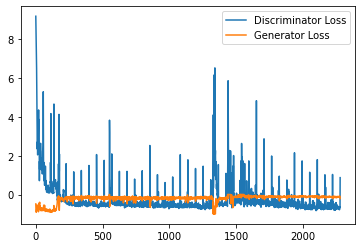

In [949]:
plt.plot(tracked_d_loss,label = "Discriminator Loss")
plt.plot(tracked_g_loss,label = "Generator Loss")
plt.legend(loc = "upper right")


plt.show()

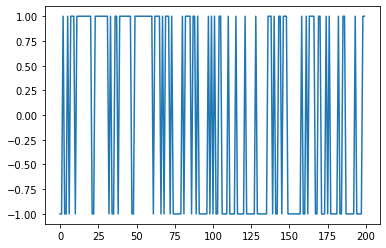

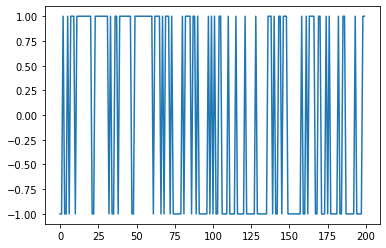

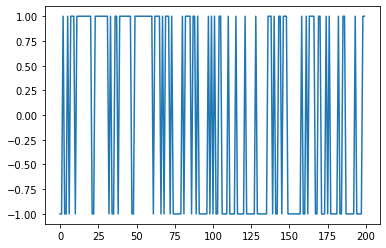

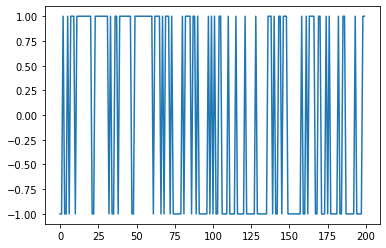

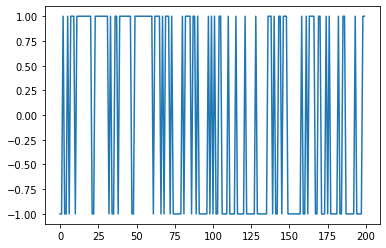

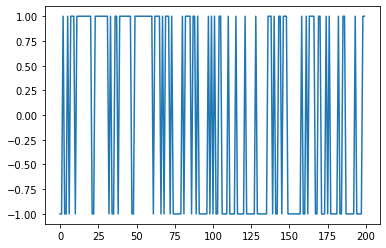

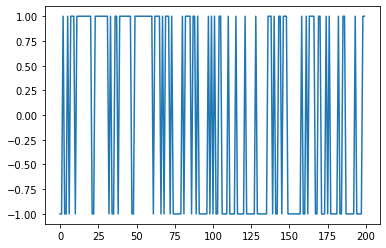

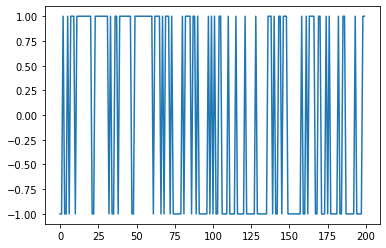

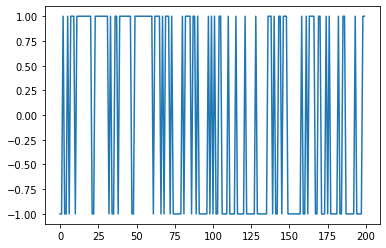

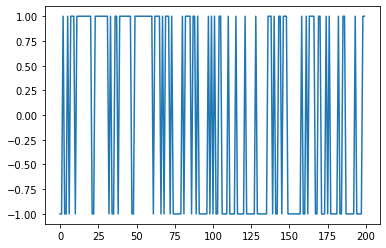

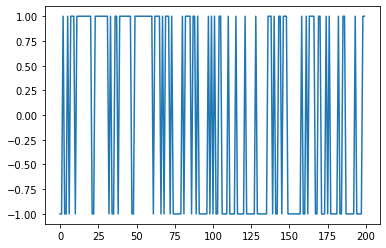

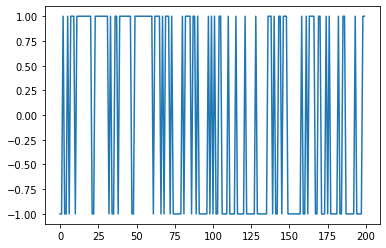

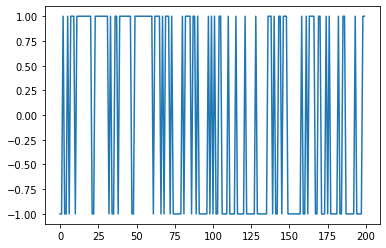

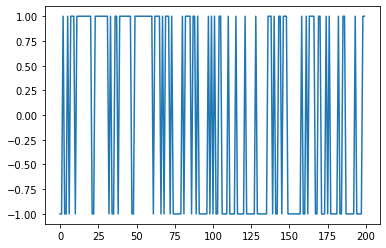

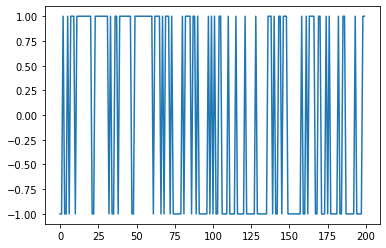

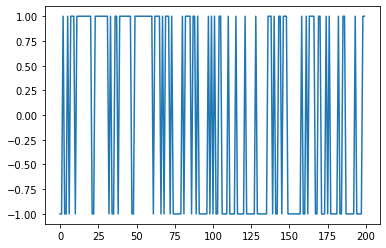

In [950]:
noise = innoise((16,1))
generated = generator(noise)
for i in generated:
    plt.plot(i.cpu().detach().numpy(),label="generated")
    plt.show()

In [951]:
noise

tensor([[1.1531],
        [1.1311],
        [1.0569],
        [0.9327],
        [1.2642],
        [1.0879],
        [1.1573],
        [0.9872],
        [1.0958],
        [1.3087],
        [1.0539],
        [1.2674],
        [1.1559],
        [1.0396],
        [1.0942],
        [0.9471]], device='cuda:0')

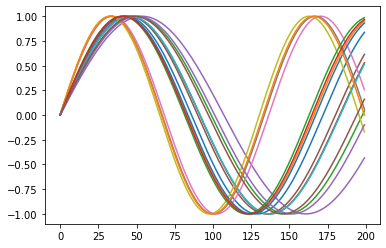

In [952]:
a = next(iter(dl))
for i in a:
    plt.plot(i)

In [953]:
type(a)

torch.Tensor

In [954]:
discriminator(a.to("cuda:0").float())

tensor([[0.9992],
        [0.9991],
        [0.9996],
        [0.9995],
        [0.9995],
        [0.9994],
        [0.9999],
        [0.9999],
        [0.9999],
        [0.9995],
        [0.9991],
        [0.9999],
        [0.9990],
        [0.9990],
        [0.9996],
        [0.9996]], device='cuda:0', grad_fn=<SigmoidBackward0>)

tensor([ 0.0197,  0.1209,  0.0327,  0.0621,  0.0593,  0.0146, -0.0943,  0.0780,
         0.0991, -0.0481, -0.1542,  0.0898,  0.0212, -0.1557,  0.1296, -0.0063,
         0.0290, -0.1159, -0.0621,  0.0161,  0.0990,  0.0242,  0.1022,  0.0913,
         0.0060,  0.1462,  0.0230,  0.0785,  0.0861, -0.0773, -0.1019,  0.0262,
         0.0945,  0.1029,  0.0021, -0.0387,  0.0672, -0.0622,  0.0414, -0.0468,
         0.0364, -0.0039,  0.0506,  0.0231, -0.0239,  0.0226, -0.0069, -0.1252,
        -0.1376, -0.0663, -0.0045, -0.0640,  0.0301,  0.1355,  0.0489,  0.0764,
         0.0407,  0.1310,  0.1593,  0.0353,  0.0742, -0.0029, -0.0530,  0.0065,
         0.1192, -0.0735, -0.0794, -0.1228, -0.0356, -0.0384, -0.0195, -0.0386,
         0.1368,  0.0491, -0.1103, -0.1703, -0.0725,  0.0596,  0.0293, -0.1129,
         0.1012,  0.0663,  0.0338, -0.0110,  0.0314, -0.0257,  0.1026, -0.0273,
         0.0391, -0.0768,  0.0868, -0.0353, -0.0477,  0.0029, -0.0648, -0.0041,
         0.0614,  0.0962,  0.0166, -0.00

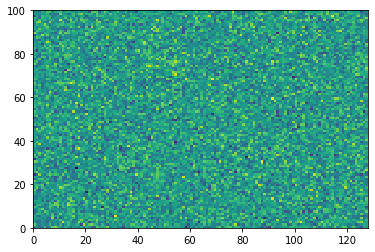

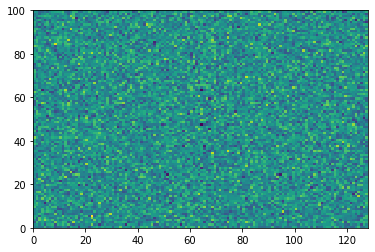

In [955]:
input1 = torch.randn(100, 128)
input2 = torch.randn(100, 128)
output = F.cosine_similarity(input1, input2)
print(output)
plt.pcolormesh(input1)
plt.show()
plt.pcolormesh(input2)
plt.show()

